In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import operator
# Non pythonic hack to reuse some utility code
if sys.path[0] != '../py_utils':
    sys.path.insert(0,'../py_utils')

import file_utils    
import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from pathlib import Path
%matplotlib inline
pd.set_option('display.max_columns', 500)
print("Seaborn version: ", sns.__version__)

Seaborn version:  0.9.0


In [7]:
def get_missed_predictions(tourney_comp_ratings, model_features, numeric_feature_to_scale,
                           prediction_probabilities, X, y, y_pred):
    
    pred_probs = pd.Series(prediction_probabilities[:,1], index=X.index)
    predictions = pd.Series(y_pred, index=y.index)
    test_games = tourney_comp_ratings[tourney_comp_ratings.index.isin(X.index)].copy()
    test_games[numeric_feature_to_scale] = scaler.inverse_transform(test_games[numeric_feature_to_scale])
    test_games['predicted_result'] = predictions
    test_games['pred_win_prob'] = pred_probs
    missed_predictions = test_games[test_games['game_result'] != 
                                test_games['predicted_result']].sort_values(by='pred_win_prob', ascending=False)
   
    missed_predictions.apply(lambda x: feature_dictionary.print_game_info(test_games,x['season_t'], x['round'], x['team_t'] ), axis=1)
    supporting_features = missed_predictions.apply(lambda row: utils.get_supporting_features(row,
                                                                                         feature_dictionary, 
                                                                                         feature_list),axis=1)

    supporting_model_features = missed_predictions.apply(lambda row: utils.get_supporting_features(row, 
                                                                                               feature_dictionary,
                                                                                               model_features),axis=1)
    
    missed_predictions = missed_predictions.merge(supporting_features.to_frame(name='supporting_features'),how='left',
                                              left_index=True, right_index=True)

    missed_predictions = missed_predictions.merge(supporting_model_features.to_frame(name='supporting_model_features'),how='left', 
                                              left_index=True, right_index=True)

    missed_predictions['features'] = 100 * missed_predictions['supporting_features'].apply(lambda x: len(x)) / len(feature_list)

    missed_predictions['model_features'] = 100 * missed_predictions['supporting_model_features'].apply(lambda x: len(x)) / \
        len(model_features)

    missed_predictions['game_index'] = missed_predictions.index
    
    return missed_predictions

In [8]:
def eliminate_features_logistic_regression(classifier, X, y ):
    iteration = 0
    print("Iteration= ", iteration)
    iteration += 1
    model_stats = {}
    drop_list = []
    # get baseline by identifying sorted important features using all of the provided features
    model_stats = utils.save_model_stats(classifier,X,y,model_stats)
    important_features = utils.display_important_features(classifier.coef_[0], X,0)
    #important_features = display_important_features_regression(classifier, X,0)
    # least important feature
    least_important_label = important_features[-1][0]
    print("least_important label= ", least_important_label)
    
    drop_list.append(least_important_label)
    del important_features[-1]
    
    # drop list contains all of the feature labels except for the feature label identified as being most important
    list_count = len(important_features)
    while list_count > 0:
        print("Iteration= ", iteration)
        iteration += 1
        model_stats = utils.save_model_stats(classifier,X.drop(columns=drop_list),y,model_stats)
        least_important_label = important_features[-1][0]
        print("least_important label= ", least_important_label)
        drop_list.append(least_important_label)
        del important_features[-1]
        list_count-=1
    return model_stats

In [9]:
summary_team_file = '../Data/sr_summaries_kaggle_id_no_opp_2018.csv'
team_meta_data_file = '../Data/D1_teams.csv'
tournament_data_file = '../Data/tournament_results_2018.csv'
rankings_data_file = '../Data/massey_seasons_with_id.csv'

feature_dictionary = utils.Feature_Dictionary()

In [10]:
# Do not use 2017-2018  for training, we'll hold that data back for testing a season in isolation

# These dates correspond to the year in which the tournament was played.
# For a start tournament date of 2003, the corresponding season is 2002-2003
start_tournament = 2003
stop_tournament = 2017

#### Read in regular season team statistics from SRCBB https://www.sports-reference.com/cbb/

#### Read table of team names and associated team meta data from the Kaggle data set.
https://console.cloud.google.com/bigquery?project=bigqueryncaa&p=bigquery-public-data&d=ncaa_basketball&page=dataset

In [11]:
# The season field in the summary data corresponds to the starting year of the season (e.g. 2000 for 2000-2001 season)
summary_data = file_utils.read_summary_team_data(summary_team_file)
teams = file_utils.read_team_meta_data(team_meta_data_file)
summary_data.head()

,season,school,team_id,games,srs,sos,win_pct,pts_avg,opp_pts_avg,fg_pct,ft_pct,poss_avg,off_rebs_avg,def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg
0,2000,Air Force,aa7af640-5762-4686-9181-39f7b8a8186e,29,-3.57,1.99,0.276,57,63,0.435,0.697,63.020690,6.0,16.0,13,7,90.446487,16
1,2000,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,28,-3.09,1.67,0.429,67,72,0.452,0.725,73.857143,9.0,20.0,15,5,90.715667,23
2,2000,Alabama,c2104cdc-c83d-40d2-a3cd-df986e29f5d3,36,14.02,6.27,0.694,76,68,0.433,0.698,86.200000,16.0,26.0,15,7,88.167053,24
3,2000,Alabama A&M,949c3398-85e4-4c63-ba71-9a82e06ddea4,28,-13.46,-11.79,0.607,73,74,0.391,0.626,94.264286,17.0,22.0,16,12,77.441843,23
4,2000,Alabama State,267d417a-8f85-4c87-a15a-068c089a74c6,31,-8.86,-13.61,0.710,68,63,0.441,0.658,80.690323,12.0,25.0,16,8,84.272807,22


#### Summary table above contains seasonal summary statistics for division one teams.

In [12]:
# Check the starting season (not tournament year) for the summary data
summary_data['season'].describe()

count    6024.000000
mean     2008.697211
std         5.186793
min      2000.000000
25%      2004.000000
50%      2009.000000
75%      2013.000000
max      2017.000000
Name: season, dtype: float64

#### Read in the NCAA Men's Tournament.

In [13]:
# The season in the tournamnet data corresponds to the year the tournament occurs (e.g. 2003 for season 2002-2003)
tourney_data = file_utils.read_tournament_results(tournament_data_file,start_tournament)
tourney_data.describe()


,season,round,win_seed,win_pts,lose_seed,lose_pts
count,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000
mean,2010.591603,44.274809,5.151718,75.154580,8.818702,63.745229
std,4.611062,22.442644,3.994370,10.758749,4.627433,10.353124
min,2003.000000,2.000000,1.000000,47.000000,1.000000,29.000000
25%,2007.000000,32.000000,2.000000,68.000000,5.000000,57.000000
50%,2011.000000,64.000000,4.000000,75.000000,9.000000,63.000000
75%,2015.000000,64.000000,8.000000,82.000000,13.000000,71.000000
max,2018.000000,68.000000,16.000000,121.000000,16.000000,105.000000


In [14]:
tourney_data.head()

,season,round,game_date,win_seed,win_market,win_team_id,win_pts,lose_seed,lose_market,lose_team_id,lose_pts
1136,2003,64,2003-03-21 00:00:00.0000000,9,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,60,8,Oregon,1da70895-f77f-44ef-b216-d63c02e696eb,58
1137,2003,64,2003-03-21 00:00:00.0000000,2,Florida,912f8837-1d81-4ef9-a576-a21f271d4c64,85,15,Sam Houston State,67322042-9c40-4dc2-b33a-4754c02ec82a,55
1138,2003,32,2003-03-23 00:00:00.0000000,10,Auburn,0c0608b3-f349-4f5e-9a10-7e6a744dd0d2,68,2,Wake Forest,4fbebf0a-e117-4a0c-8f15-c247535a2a1b,62
1139,2003,64,2003-03-21 00:00:00.0000000,10,Auburn,0c0608b3-f349-4f5e-9a10-7e6a744dd0d2,65,7,Saint Joseph's (PA),f9e4261e-d11d-46c4-bd33-c7bbc94ef0e8,63
1140,2003,4,2003-04-05 00:00:00.0000000,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,95,1,Texas,6ed15092-2670-450a-99c2-61d861e87644,84


In [15]:
game_data = utils.compute_game_data(tourney_data, teams)

# The season year in the computer rankings file correspond to the tournament year (e.g. 2003 for 2002-2003 season)
computer_rankings = pd.read_csv(Path(rankings_data_file))
computer_rankings = computer_rankings[computer_rankings['season'] >= start_tournament]

# Recoding the tourney data to generate team and opp_team fields to replace win and lose fields
# Also add a start season field to the tourney data for merging with summary data
tourney_data = utils.recode_tourney_data(tourney_data)

# Merge the tourney data with the summary data. Handle the discrepancy in the season encodings. 
tourney_data = file_utils.merge_tourney_summary_data(tourney_data, summary_data)

tourney_data = file_utils.join_tourney_team_data(tourney_data, teams)

# Add computer ranking data to team data
tourney_comp_ratings = file_utils.merge_tourney_ranking_data(tourney_data, computer_rankings)
tourney_comp_ratings = utils.implement_top_conference_feature(game_data, tourney_comp_ratings)
tourney_comp_ratings = utils.implement_seed_threshold_feature(tourney_comp_ratings)
tourney_comp_ratings = utils.compute_delta_features(tourney_comp_ratings)

tourney_comp_ratings.dropna(inplace=True)
tourney_comp_ratings[tourney_comp_ratings.isnull().any(axis=1)]


,season_t,round,game_date,seed_t,team_t,team_id_t,win_pts,seed_o,team_o,team_id_o,lose_pts,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_mor


In [16]:
tourney_comp_ratings.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,win_pts,seed_o,team_o,team_id_o,lose_pts,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_mor
0,2003,64,2003-03-21 00:00:00.0000000,8,Oregon,1da70895-f77f-44ef-b216-d63c02e696eb,60,9,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,58,-1,2002,Lose,14.05,6.11,0.697,81.0,73.0,0.458,0.774,85.363636,11.0,24.0,15.0,7.0,94.888179,20.0,11.00,5.25,0.758,66.0,60.0,0.451,0.711,71.333333,10.0,23.0,12.0,4.0,92.523364,18.0,Pacific 12,Pacific 12,30,43.0,33,36,32.0,42.0,29.0,50.0,27,38,31.0,25,34,20.0,37.0,33.0,16.0,66,0,0,0,8.0,6.0,2.0,0.007,1.0,1.0,0.063,8.0,8.0,0.0,-0.061,2.364814,2.0,-1,3.05,0.86,-8,12.0,8,2,12.0,5.0,-4.0,-39
1,2003,64,2003-03-21 00:00:00.0000000,2,Florida,912f8837-1d81-4ef9-a576-a21f271d4c64,85,15,Sam Houston State,67322042-9c40-4dc2-b33a-4754c02ec82a,55,1,2002,Win,18.54,7.76,0.758,75.0,64.0,0.476,0.703,76.945455,10.0,24.0,13.0,7.0,97.471645,18.0,-1.65,-6.87,0.767,72.0,65.0,0.459,0.705,79.620000,11.0,25.0,15.0,8.0,90.429540,23.0,Southeastern,Southland,7,11.0,11,10,14.0,6.0,8.0,15.0,7,138,102.0,115,143,87.0,134.0,93.0,91.0,169,1,0,1,11.0,7.0,4.0,0.017,-1.0,-1.0,-0.002,6.0,7.0,-1.0,-0.009,7.042104,-5.0,-13,20.19,14.63,-131,-91.0,-104,-133,-73.0,-128.0,-85.0,-162
2,2003,32,2003-03-23 00:00:00.0000000,2,Wake Forest,4fbebf0a-e117-4a0c-8f15-c247535a2a1b,68,10,Auburn,0c0608b3-f349-4f5e-9a10-7e6a744dd0d2,62,-1,2002,Lose,16.96,6.96,0.806,77.0,67.0,0.453,0.752,83.167742,14.0,26.0,15.0,6.0,92.583973,26.0,12.68,8.34,0.647,70.0,65.0,0.465,0.660,79.558824,12.0,23.0,15.0,7.0,87.985213,20.0,Atlantic Coast,Southeastern,9,9.0,4,7,8.0,12.0,4.0,7.0,20,43,47.0,40,40,44.0,45.0,43.0,36.0,44,0,0,1,10.0,5.0,5.0,-0.012,2.0,3.0,0.092,9.0,8.0,1.0,0.159,4.598761,6.0,-8,4.28,-1.38,-34,-38.0,-36,-33,-36.0,-33.0,-39.0,-24
3,2003,64,2003-03-21 00:00:00.0000000,10,Auburn,0c0608b3-f349-4f5e-9a10-7e6a744dd0d2,65,7,Saint Joseph's (PA),f9e4261e-d11d-46c4-bd33-c7bbc94ef0e8,63,1,2002,Win,12.68,8.34,0.647,70.0,65.0,0.465,0.660,79.558824,12.0,23.0,15.0,7.0,87.985213,20.0,14.61,3.71,0.767,70.0,59.0,0.443,0.686,75.666667,11.0,24.0,12.0,7.0,92.511013,20.0,Southeastern,Atlantic 10,43,47.0,40,40,44.0,45.0,43.0,36.0,44,20,16.0,27,28,27.0,18.0,22.0,27.0,38,1,0,0,5.0,11.0,-6.0,0.022,1.0,-1.0,-0.026,8.0,5.0,3.0,-0.120,-4.525801,0.0,3,-1.93,4.63,23,31.0,13,12,17.0,27.0,21.0,6
4,2003,4,2003-04-05 00:00:00.0000000,1,Texas,6ed15092-2670-450a-99c2-61d861e87644,95,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,84,-1,2002,Lose,18.91,9.27,0.788,79.0,69.0,0.446,0.721,85.248485,16.0,25.0,13.0,6.0,92.670269,24.0,19.02,9.02,0.857,79.0,69.0,0.475,0.694,84.640000,13.0,27.0,14.0,8.0,93.336484,23.0,Big 12,Atlantic Coast,5,7.0,7,6,4.0,7.0,7.0,4.0,12,12,14.0,5,12,9.0,15.0,5.0,9.0,21,0,0,0,10.0,10.0,0.0,-0.029,3.0,-2.0,0.027,7.0,6.0,1.0,-0.069,-0.666215,1.0,-2,-0.11,0.25,-7,-7.0,2,-6,-5.0,-8.0,2.0,-9


In [17]:
tourney_comp_ratings.describe()

,season_t,round,seed_t,win_pts,seed_o,lose_pts,game_result,start_season,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_mor
count,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000
mean,2010.607656,44.210526,7.087081,75.135885,6.845933,63.734928,-0.000957,2009.607656,14.028335,5.530660,0.744365,73.857416,64.950239,0.460840,0.707440,77.899113,11.133971,23.879426,12.097608,6.520574,94.843805,20.910048,14.265703,5.644019,0.746697,73.882297,64.856459,0.461457,0.708194,77.927647,11.177033,23.975120,12.117703,6.457416,94.852399,20.956938,41.624880,39.409569,38.815311,43.102392,38.729187,41.668900,39.401914,37.397129,43.454545,39.546411,37.558852,37.019139,40.934928,36.905263,39.953110,37.828708,36.063158,41.761722,0.241148,0.238278,0.475598,8.907177,9.025837,-0.118660,-0.000617,-0.043062,-0.095694,-0.000754,5.577033,5.660287,-0.083254,-0.002332,-0.008594,-0.046890,0.241148,-0.237368,-0.113359,2.078469,1.850718,1.796172,2.167464,1.823923,1.715789,1.573206,1.692823
std,4.607293,22.442470,4.697668,10.754252,4.658675,10.357664,1.000478,4.607293,7.581008,4.758944,0.096800,5.243657,4.654069,0.022487,0.035885,4.384704,1.842257,2.135453,1.671271,1.340787,4.779402,2.620203,7.485940,4.774284,0.097354,5.043729,4.667741,0.021874,0.034975,4.378116,1.849264,2.198779,1.708252,1.376233,4.658676,2.761091,50.993022,47.266513,45.542046,53.712143,45.150243,50.249926,47.383808,42.176061,52.664767,49.902942,46.881399,45.526692,52.477523,44.985094,49.892247,47.205899,42.289708,51.707100,0.427985,0.426234,0.499643,4.243543,4.229787,6.113963,0.031684,2.540300,2.553720,0.050656,1.851025,1.794095,2.500911,0.137027,6.456617,3.629211,7.464683,11.096737,6.884305,69.523609,64.192081,61.678327,73.700633,61.313728,69.249290,64.041127,73.124929
min,2003.000000,2.000000,1.000000,47.000000,1.000000,29.000000,-1.000000,2002.000000,-14.510000,-12.120000,0.406000,59.000000,51.000000,0.380000,0.591000,62.412903,5.000000,17.000000,7.000000,3.000000,76.996634,13.000000,-15.280000,-12.860000,0.412000,59.000000,50.000000,0.394000,0.612000,59.144828,5.000000,15.000000,7.000000,3.000000,79.371255,12.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-7.000000,-6.000000,-21.000000,-0.094000,-8.000000,-9.000000,-

In [18]:
numeric_features = ['delta_margin_victory_avg', 'delta_fg_pct', 'delta_off_rebs_avg',
                            'delta_def_rebs_avg', 'delta_ft_pct',
                            'delta_to_net_avg', 'delta_win_pct', 'delta_off_rating',
                            'delta_ft_att_avg',
                            'delta_seed', 'delta_srs', 'delta_sos',
                            'delta_sag', 'delta_wlk', 'delta_wol',
                            'delta_rth', 'delta_col', 'delta_pom',
                            'delta_dol', 'delta_mor']

# Convert types to float to eliminate needless scaler warning 
for item in numeric_features:
    tourney_comp_ratings[item] = tourney_comp_ratings[item].astype(float)


In [19]:
feature_columns = numeric_features  + ['season_t', 'top_conf_t', 'top_conf_o']
feature_data = tourney_comp_ratings[feature_columns].copy()
feature_data.head()

,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_mor,season_t,top_conf_t,top_conf_o
0,2.0,0.007,1.0,1.0,0.063,0.0,-0.061,2.364814,2.0,-1.0,3.05,0.86,-8.0,12.0,8.0,2.0,12.0,5.0,-4.0,-39.0,2003,0,0
1,4.0,0.017,-1.0,-1.0,-0.002,-1.0,-0.009,7.042104,-5.0,-13.0,20.19,14.63,-131.0,-91.0,-104.0,-133.0,-73.0,-128.0,-85.0,-162.0,2003,1,0
2,5.0,-0.012,2.0,3.0,0.092,1.0,0.159,4.598761,6.0,-8.0,4.28,-1.38,-34.0,-38.0,-36.0,-33.0,-36.0,-33.0,-39.0,-24.0,2003,0,0
3,-6.0,0.022,1.0,-1.0,-0.026,3.0,-0.120,-4.525801,0.0,3.0,-1.93,4.63,23.0,31.0,13.0,12.0,17.0,27.0,21.0,6.0,2003,1,0
4,0.0,-0.029,3.0,-2.0,0.027,1.0,-0.069,-0.666215,1.0,-2.0,-0.11,0.25,-7.0,-7.0,2.0,-6.0,-5.0,-8.0,2.0,-9.0,2003,0,0


In [20]:
X= feature_data[feature_data['season_t']<= stop_tournament]
X['season_t'].describe()

count     978.000000
mean     2010.101227
std         4.321873
min      2003.000000
25%      2006.000000
50%      2010.000000
75%      2014.000000
max      2017.000000
Name: season_t, dtype: float64

In [21]:
y=tourney_comp_ratings[tourney_comp_ratings['season_t']<= stop_tournament]['game_result']
X= X.drop(columns=['season_t'])

feature_list = list(X)
feature_list

['delta_margin_victory_avg',
 'delta_fg_pct',
 'delta_off_rebs_avg',
 'delta_def_rebs_avg',
 'delta_ft_pct',
 'delta_to_net_avg',
 'delta_win_pct',
 'delta_off_rating',
 'delta_ft_att_avg',
 'delta_seed',
 'delta_srs',
 'delta_sos',
 'delta_sag',
 'delta_wlk',
 'delta_wol',
 'delta_rth',
 'delta_col',
 'delta_pom',
 'delta_dol',
 'delta_mor',
 'top_conf_t',
 'top_conf_o']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
X_train = X_train.copy()
X_test = X_test.copy()
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_train.head()

(782, 22)
(782,)
(196, 22)
(196,)


,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_mor,top_conf_t,top_conf_o
784,-3.0,-0.015,0.0,-1.0,0.062,2.0,-0.055,-3.232509,-1.0,3.0,-10.13,-6.65,97.0,106.0,98.0,94.0,88.0,80.0,103.0,102.0,0,1
125,8.0,0.011,-2.0,0.0,-0.039,-1.0,0.262,8.822234,-1.0,-7.0,5.32,-3.24,-24.0,-33.0,-25.0,-25.0,-28.0,-24.0,-30.0,-19.0,0,1
236,3.0,0.022,-4.0,-3.0,0.071,-3.0,0.139,12.896390,4.0,-3.0,4.23,0.00,-11.0,-11.0,-15.0,-13.0,-14.0,-12.0,-18.0,-14.0,0,0
719,0.0,-0.010,0.0,-2.0,-0.016,1.0,0.043,-2.544287,-4.0,0.0,-1.24,0.41,8.0,1.0,3.0,2.0,-4.0,-16.0,12.0,-7.0,0,0
808,0.0,-0.046,5.0,2.0,-0.051,4.0,-0.008,-7.831221,1.0,-11.0,12.38,11.36,-64.0,-66.0,-58.0,-98.0,-79.0,-56.0,-78.0,-73.0,1,0


#### Scale the input data.   
#### Mention Data Snooping.
Note the scaler is fit only with the training data to establish the mean and standard deviation used to scale the data.

In [23]:
scaler=StandardScaler(copy=True, with_mean=True, with_std=True)

scaler.fit(X_train[numeric_features])
X_train[numeric_features] = scaler.transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

In [24]:
X_train.head()

,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_mor,top_conf_t,top_conf_o
784,-0.443453,-0.445832,0.015757,-0.355203,1.257461,0.803690,-0.343973,-0.487040,-0.255700,0.338099,-0.857533,-0.924076,1.334835,1.596198,1.500709,1.207237,1.355069,1.111120,1.530136,1.342604,0,1
125,1.347432,0.368456,-0.779195,0.029518,-0.768337,-0.397238,1.939666,1.405681,-0.255700,-1.002637,0.531418,-0.429216,-0.402602,-0.572163,-0.456541,-0.398834,-0.508924,-0.400711,-0.518252,-0.312402,0,1
236,0.533393,0.712963,-1.574147,-1.124647,1.437978,-1.197856,1.053586,2.045366,1.136763,-0.466343,0.433427,0.040973,-0.215936,-0.228969,-0.297415,-0.236877,-0.283959,-0.226269,-0.333435,-0.244013,0,0
719,0.044970,-0.289238,0.015757,-0.739925,-0.307017,0.403381,0.362010,-0.378982,-1.091178,-0.064122,-0.058324,0.100473,0.056885,-0.041772,-0.010988,-0.034431,-0.123270,-0.284416,0.128608,-0.148269,0,0
808,0.044970,-1.416714,2.003136,0.798962,-1.009026,1.604308,-0.005389,-1.209086,0.301285,-1.538931,1.166110,1.689539,-0.976962,-1.086953,-0.981657,-1.384071,-1.328438,-0.865890,-1.257519,-1.050999,1,0


#### Baseline Model

In [25]:
logreg = LogisticRegression(solver='liblinear')

result = logreg.fit(X_train,y_train)

print("Coeffs ",logreg.coef_)
print("Intercept ", logreg.intercept_)

Coeffs  [[-0.8461553  -0.07241055  0.08806765 -0.06299594 -0.01729832 -0.07312713
   3.53846648  0.08638712 -0.13605243  1.31640607  2.45468387  3.1608614
  -0.29897729 -0.29844189 -0.71818474  0.86349711  2.31955106  0.29893757
   1.7901119  -0.34845503  0.20270092 -0.0466943 ]]
Intercept  [-0.11056173]


In [26]:
utils.display_important_features(logreg.coef_[0], X_train,1)

Coefficient Values
delta_win_pct   3.5384664786537856
delta_sos   3.1608614033011633
delta_srs   2.454683873013918
delta_col   2.3195510619685415
delta_dol   1.7901119012680882
delta_seed   1.3164060706289635
delta_rth   0.8634971146405636
delta_margin_victory_avg   -0.8461553044451183
delta_wol   -0.7181847435618747
delta_mor   -0.3484550255686728
delta_sag   -0.29897728806861473
delta_pom   0.29893756886073963
delta_wlk   -0.2984418865621623
top_conf_t   0.20270091961001613
delta_ft_att_avg   -0.13605242762864814
delta_off_rebs_avg   0.08806765135180154
delta_off_rating   0.08638711563980492
delta_to_net_avg   -0.07312712542049424
delta_fg_pct   -0.0724105539253013
delta_def_rebs_avg   -0.06299593617790164
top_conf_o   -0.04669429757751333
delta_ft_pct   -0.017298321627489482


[('delta_win_pct', 3.5384664786537856),
 ('delta_sos', 3.1608614033011633),
 ('delta_srs', 2.454683873013918),
 ('delta_col', 2.3195510619685415),
 ('delta_dol', 1.7901119012680882),
 ('delta_seed', 1.3164060706289635),
 ('delta_rth', 0.8634971146405636),
 ('delta_margin_victory_avg', -0.8461553044451183),
 ('delta_wol', -0.7181847435618747),
 ('delta_mor', -0.3484550255686728),
 ('delta_sag', -0.29897728806861473),
 ('delta_pom', 0.29893756886073963),
 ('delta_wlk', -0.2984418865621623),
 ('top_conf_t', 0.20270091961001613),
 ('delta_ft_att_avg', -0.13605242762864814),
 ('delta_off_rebs_avg', 0.08806765135180154),
 ('delta_off_rating', 0.08638711563980492),
 ('delta_to_net_avg', -0.07312712542049424),
 ('delta_fg_pct', -0.0724105539253013),
 ('delta_def_rebs_avg', -0.06299593617790164),
 ('top_conf_o', -0.04669429757751333),
 ('delta_ft_pct', -0.017298321627489482)]

In [27]:
y_pred = logreg.predict(X_test)

array([[67, 22],
       [18, 89]], dtype=int64)

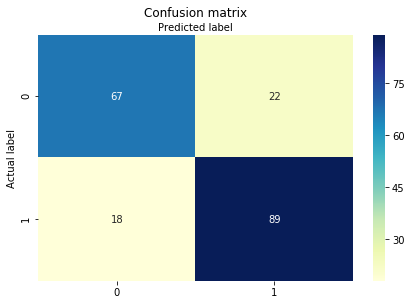

In [28]:
utils.display_confusion_matrix(y_test, y_pred)

In [29]:
prediction_probabilities = logreg.predict_proba(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Log loss= ",log_loss(y_test, prediction_probabilities))

Accuracy: 0.7959183673469388
Precision: 0.8018018018018018
Recall: 0.8317757009345794
Log loss=  0.4660298675307945


#### Learning Curve

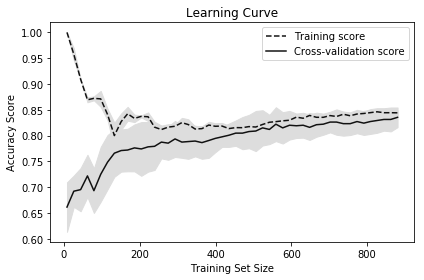

In [30]:
X_copy = X.copy()
scaler.fit(X_copy[numeric_features])
X_copy[numeric_features] = scaler.transform(X_copy[numeric_features])
train_sizes, train_scores, test_scores = learning_curve(logreg, 
                                                        X_copy, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [31]:
scores = cross_val_score(logreg, X_copy,y, cv=10, scoring='accuracy')
print(scores.mean())

0.835377656217126


#### Model Feature Optimization

In [32]:
model_stats = eliminate_features_logistic_regression(logreg, X_copy,y)

Iteration=  0
least_important label=  delta_ft_pct
Iteration=  1
least_important label=  top_conf_o
Iteration=  2
least_important label=  delta_def_rebs_avg
Iteration=  3
least_important label=  delta_to_net_avg
Iteration=  4
least_important label=  delta_fg_pct
Iteration=  5
least_important label=  delta_off_rating
Iteration=  6
least_important label=  delta_off_rebs_avg
Iteration=  7
least_important label=  delta_ft_att_avg
Iteration=  8
least_important label=  top_conf_t
Iteration=  9
least_important label=  delta_pom
Iteration=  10
least_important label=  delta_sag
Iteration=  11
least_important label=  delta_wlk
Iteration=  12
least_important label=  delta_mor
Iteration=  13
least_important label=  delta_wol
Iteration=  14
least_important label=  delta_margin_victory_avg
Iteration=  15
least_important label=  delta_rth
Iteration=  16
least_important label=  delta_seed
Iteration=  17
least_important label=  delta_dol
Iteration=  18
least_important label=  delta_col
Iteration=  19
l

In [33]:
max_accuracy = 0
max_cross_val = 0
min_log_loss = 10000
for key, value in model_stats.items():
    accuracy = value['accuracy']
    cross_val = value['cross_validation']
    log_loss_val = value['log_loss']
    print('Accuracy= {0:6.4f} Cross Val= {1:6.4f}  Log Loss= {2:6.4f}'.format(accuracy ,cross_val, log_loss_val ))
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        accuracy_hash = key
    if cross_val > max_cross_val:
        max_cross_val = cross_val
        cross_hash = key
    if log_loss_val < min_log_loss:
        min_log_loss = log_loss_val
        log_hash = key

print("\n")

print('Max Accuracy= {0:6.4f}'.format( model_stats[accuracy_hash]['accuracy']))
print('Max Cross Validation= {0:6.4f}'.format( model_stats[cross_hash]['cross_validation']))
print ("Minimum Log Loss= {0:6.4f}".format(  model_stats[log_hash]['log_loss']))
print('Log Loss at Max Accuracy= {0:6.4f}'.format( model_stats[accuracy_hash]['log_loss'] ))
print('Log Loss at Max Cross Validation= {0:6.4f} '.format( model_stats[cross_hash]['log_loss'] ))

Accuracy= 0.7959 Cross Val= 0.8354  Log Loss= 0.4658
Accuracy= 0.7959 Cross Val= 0.8385  Log Loss= 0.4659
Accuracy= 0.8010 Cross Val= 0.8354  Log Loss= 0.4662
Accuracy= 0.7959 Cross Val= 0.8364  Log Loss= 0.4663
Accuracy= 0.7959 Cross Val= 0.8344  Log Loss= 0.4669
Accuracy= 0.7908 Cross Val= 0.8323  Log Loss= 0.4660
Accuracy= 0.7908 Cross Val= 0.8323  Log Loss= 0.4656
Accuracy= 0.8010 Cross Val= 0.8354  Log Loss= 0.4651
Accuracy= 0.7857 Cross Val= 0.8323  Log Loss= 0.4687
Accuracy= 0.7959 Cross Val= 0.8375  Log Loss= 0.4687
Accuracy= 0.7959 Cross Val= 0.8374  Log Loss= 0.4687
Accuracy= 0.7959 Cross Val= 0.8385  Log Loss= 0.4686
Accuracy= 0.7959 Cross Val= 0.8323  Log Loss= 0.4712
Accuracy= 0.7959 Cross Val= 0.8343  Log Loss= 0.4723
Accuracy= 0.7857 Cross Val= 0.8292  Log Loss= 0.4787
Accuracy= 0.7806 Cross Val= 0.8272  Log Loss= 0.4835
Accuracy= 0.7755 Cross Val= 0.8282  Log Loss= 0.4865
Accuracy= 0.7398 Cross Val= 0.8160  Log Loss= 0.5213
Accuracy= 0.7092 Cross Val= 0.8017  Log Loss= 

In [34]:
model_features =model_stats[cross_hash]['labels']

print(model_features)

['delta_margin_victory_avg', 'delta_fg_pct', 'delta_off_rebs_avg', 'delta_def_rebs_avg', 'delta_to_net_avg', 'delta_win_pct', 'delta_off_rating', 'delta_ft_att_avg', 'delta_seed', 'delta_srs', 'delta_sos', 'delta_sag', 'delta_wlk', 'delta_wol', 'delta_rth', 'delta_col', 'delta_pom', 'delta_dol', 'delta_mor', 'top_conf_t', 'top_conf_o']


In [35]:
# numeric model features are the intersection of numeric features with model features
numeric_model_features = list(set(model_features).intersection(set(numeric_features)))

numeric_model_features

['delta_srs',
 'delta_ft_att_avg',
 'delta_def_rebs_avg',
 'delta_seed',
 'delta_wlk',
 'delta_rth',
 'delta_fg_pct',
 'delta_mor',
 'delta_sos',
 'delta_to_net_avg',
 'delta_sag',
 'delta_col',
 'delta_pom',
 'delta_off_rating',
 'delta_dol',
 'delta_win_pct',
 'delta_wol',
 'delta_off_rebs_avg',
 'delta_margin_victory_avg']

In [36]:
# dropped features
dropped_features = list(set(feature_list) - set(model_features))
dropped_features

['delta_ft_pct']

(782, 21)
(782,)
(196, 21)
(196,)
Accuracy: 0.7959183673469388
Precision: 0.8018018018018018
Recall: 0.8317757009345794
Log loss=  0.4661941189771039


array([[67, 22],
       [18, 89]], dtype=int64)

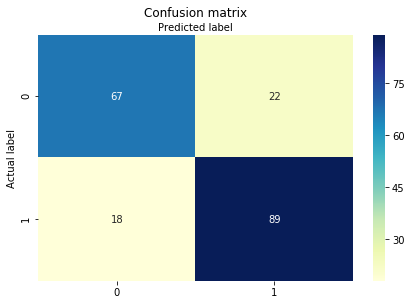

In [37]:
X_model = X[model_features].copy()
X_train, X_test, y_train, y_test = train_test_split(X_model, y, test_size=0.2, random_state= 5)
X_train = X_train.copy()
X_test = X_test.copy()
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

scaler.fit(X_train[numeric_model_features])
X_train[numeric_model_features] = scaler.transform(X_train[numeric_model_features])
X_test[numeric_model_features] = scaler.transform(X_test[numeric_model_features])

logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)
# save model stats
prediction_probabilities = logreg.predict_proba(X_test)

cross_val_scores = cross_val_score(logreg, X,y, cv=10, scoring='accuracy')
cross_validation_average = cross_val_scores.mean()

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Log loss= ",log_loss(y_test, prediction_probabilities))

utils.display_confusion_matrix(y_test, y_pred)

In [38]:
missed_predictions = get_missed_predictions(tourney_comp_ratings, model_features, numeric_model_features, 
                                            prediction_probabilities, X_test, y_test, y_pred)


                                       Kansas                   Bucknell     Stat Supports Winner
Allow PPG                       65.00                              58.00         True  (L)
FT %                            69.50                              70.10         True  (H)
Takeaway Avg                     6.00                               7.00         True  (H)
Seed                              3                                 14          False  (L)
SAG                              9.00                             114.00        False  (L)
WLK                              7.00                              97.00        False  (L)
WOL                             10.00                              84.00        False  (L)
RTH                              7.00                             137.00        False  (L)
COL                              4.00                             102.00        False  (L)
POM                             12.00                             110.00        Fal


                                     Syracuse                     Dayton     Stat Supports Winner
PPG                             67.00                              72.00         True  (H)
Poss Avg                        72.50                              75.34         True  (H)
FG %                            43.70                              46.30         True  (H)
Def Rb Avg                      22.00                              23.00         True  (H)
FT ATT Avg                      21.00                              22.00         True  (H)
Off Rating                      92.41                              95.57         True  (H)
Seed                              3                                 11          False  (L)
SAG                             19.00                              58.00        False  (L)
WLK                             18.00                              54.00        False  (L)
WOL                              5.00                              44.00        Fa

In [39]:
missed_predictions

,season_t,round,game_date,seed_t,team_t,team_id_t,win_pts,seed_o,team_o,team_id_o,lose_pts,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_mor,predicted_result,pred_win_prob,supporting_features,supporting_model_features,features,model_features,game_index
128,2005,64,2005-03-18 00:00:00.0000000,3,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,64,14,Bucknell,98d2123a-c7b9-4b5f-8a81-43f76d8537dc,63,-1,2004,Lose,20.68,10.85,0.767,75.0,65.0,0.476,0.695,79.220000,11.0,25.0,14.0,6.0,94.673062,21.0,2.12,-2.19,0.697,63.0,58.0,0.444,0.701,71.569697,9.0,22.0,15.0,7.0,88.026082,20.0,Big 12,Patriot League,9,7.0,10,7,4.0,12.0,8.0,1.0,19,114,97.0,84,137,102.0,110.0,87.0,64.0,151,1,0,1,10.0,5.0,30.434848,0.000257,4.992109,7.721116,-0.006,8.0,8.0,-0.007673,0.002465,42.204080,3.508919,-81.566256,205.861021,89.574173,-7308.456917,-5765.657430,-4646.710555,-9627.650182,-6095.062502,-6737.931340,-5125.750651,-9646.881447,1,0.981620,[ft_pct],[],4.545455,0.000000,128
816,2015,32,2015-03-21 00:00:00.0000000,1,Villanova,4383eb6a-7fd8-4ff2-94c5-43c933121e88,71,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,68,-1,2014,Lose,23.13,7.55,0.917,76.0,60.0,0.470,0.731,73.861111,10.0,24.0,10.0,7.0,102.895825,22.0,14.11,9.72,0.611,70.0,65.0,0.436,0.686,75.550000,12.0,25.0,10.0,3.0,92.653872,20.0,Big East,Atlantic Coast,6,4.0,2,2,2.0,5.0,2.0,2.0,4,32,33.0,40,32,40.0,38.0,40.0,39.0,22,0,0,1,16.0,5.0,67.288123,0.000321,-5.071393,-2.676007,0.045,3.0,7.0,-9.999950,0.035225,65.100472,7.099679,-51.731886,99.742785,-15.235456,-1806.674754,-1855.330253,-2384.353267,-2218.264541,-2361.143814,-2266.530562,-2463.656841,-1312.167338,1,0.980141,"[off_rebs_avg, def_rebs_avg, sos]","[off_rebs_avg, def_rebs_avg, sos]",13.636364,14.285714,816
178,2005,32,2005-03-19 00:00:00.0000000,2,Wake Forest,4fbebf0a-e117-4a0c-8f15-c247535a2a1b,111,7,West Virginia,f770d3a2-221c-49ce-9c7a-680f7417fe9e,105,-1,2004,Lose,20.24,10.27,0.818,84.0,73.0,0.491,0.684,85.224242,14.0,25.0,14.0,8.0,98.563504,27.0,11.76,7.62,0.686,71.0,67.0,0.450,0.742,73.782857,9.0,20.0,11.0,8.0,96.228315,17.0,Atlantic Coast,Big 12,4,4.0,3,4,6.0,5.0,3.0,7.0,5,38,39.0,28,32,34.0,35.0,30.0,34.0,30,0,0,0,11.0,4.0,42.719273,0.000544,12.539737,12.919678,-0.058,6.0,3.0,7.486535,0.011071,14.742276,35.825759,-36.814701,93.736093,17.978378,-2363.817251,-2239.952598,-1567.390913,-2070.076829,-1738.824032,-2060.158219,-1749.436551,-1823.948029,1,0.931288,"[ft_pct, to_net_avg]",[to_net_avg],9.090909,4.761905,178
778,2014,64,2014-03-21 00:00:00.0000000,3,Duke,faeb1160-5d15-4f26-99fc-c441cf21fc7f,78,14,Mercer,a14b0057-8eb5-43d2-a33b-666196da933e,71,-1,2013,Lose,19.51,8.48,0.743,78.0,67.0,0.460,0.729,76.034286,11.0,22.0,9.0,6.0,102.585300,22.0,5.33,-3.42,0.750,78.0,66.0,0.476,0.736,77.705556,11.0,25.0,11.0,5.0,100.378923,21.0,Atlantic Coast,Southern,7,8.0,15,9,14.0,6.0,14.0,9.0,8,89,97.0,90,124,93.0,95.0,100.0,81.0,94,1,0,1,11.0,12.0,-6.418427,-0.001276,-0.039642,-7.874569,-0.007,3.0,6.0,-7.501881,-0.008224,13.921864,3.508919,-81.566256,157.140070,81.718619,-5706.672237,-5701.553706,-4709.553813,-8516.242336,-4912.654917,-6118.814309,-5580.254472,-6283.751192,1,0.878637,"[margin_victory_avg, fg_pct, def_rebs_avg, ft_...","[margin_victory_avg, fg_

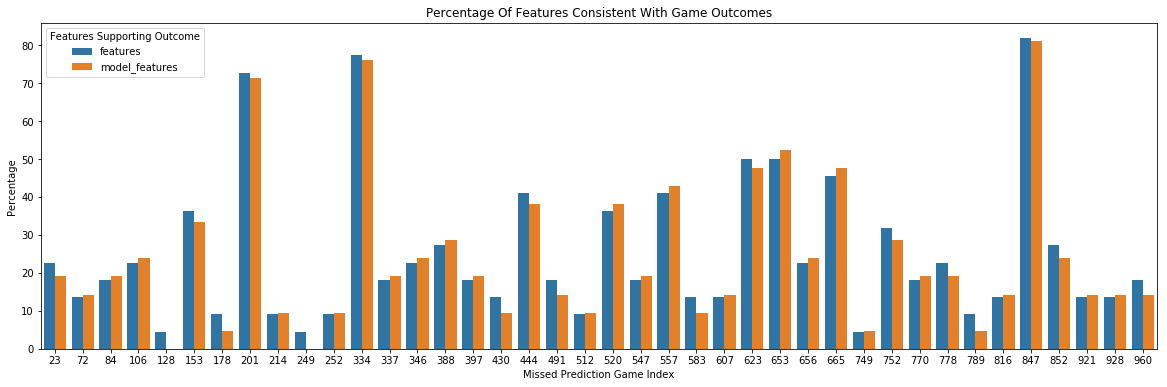

In [40]:
plot_missed_predictions_df = missed_predictions[['game_index','features','model_features']]
plot_missed_predictions_df = pd.melt(plot_missed_predictions_df, id_vars='game_index', var_name= 'Features Supporting Outcome')
m_plot = sns.barplot(x='game_index', y='value', hue='Features Supporting Outcome', data= plot_missed_predictions_df) 
plt.title("Percentage Of Features Consistent With Game Outcomes")
plt.ylabel('Percentage')
plt.xlabel('Missed Prediction Game Index')
m_plot.figure.set_size_inches(20,6)

##### The bar chart depicts the percentage of features that correctly corresponded to the game outcome but were out weighed by other features in predicting the game incorrectly. Games corresponding to bar heights exceeding 50% should be scrutinized.

In [41]:
missed_predictions[missed_predictions['game_index']==201]

,season_t,round,game_date,seed_t,team_t,team_id_t,win_pts,seed_o,team_o,team_id_o,lose_pts,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_mor,predicted_result,pred_win_prob,supporting_features,supporting_model_features,features,model_features,game_index
201,2006,64,2006-03-17 00:00:00.0000000,10,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,58,7,California,aacdc78d-b7fa-48f6-9686-2fdb8a95030e,52,1,2005,Win,12.7,5.63,0.688,74.0,67.0,0.465,0.751,75.2875,8.0,23.0,13.0,7.0,98.289889,21.0,12.31,8.84,0.645,68.0,64.0,0.449,0.733,73.174194,9.0,22.0,12.0,5.0,92.928937,23.0,Atlantic Coast,Pacific 12,24,36.0,31,25,36.0,25.0,30.0,51.0,28,51,51.0,55,43,47.0,50.0,40.0,52.0,46,0,0,0,7.0,4.0,18.150423,-0.000254,-2.555518,2.522555,0.018,6.0,7.0,-2.505742,-0.001283,34.013362,-7.263362,22.854038,3.746939,-22.401927,-1876.317566,-957.878114,-1504.547655,-1329.138264,-680.880404,-1716.204313,-645.641557,-1312.167338,-1,0.36344,"[margin_victory_avg, fg_pct, def_rebs_avg, ft_...","[margin_victory_avg, fg_pct, def_rebs_avg, to_...",72.727273,71.428571,201


### Run Model Against 2018 Tournament

In [42]:
test_year = 2018

# scale the feature data corresponding to the 2018 tournament
feature_copy = feature_data[feature_data['season_t'] == test_year].copy()

feature_copy.head()

,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_mor,season_t,top_conf_t,top_conf_o
981,2.0,-0.030,1.0,-4.0,0.029,-3.0,0.125,-4.274284,-5.0,0.0,6.00,4.11,-65.0,-72.0,-85.0,-82.0,-79.0,-82.0,-85.0,-40.0,2018,0,0
982,-1.0,0.009,0.0,3.0,-0.032,3.0,-0.129,0.896029,-2.0,0.0,3.20,4.25,-16.0,-15.0,16.0,-16.0,3.0,-21.0,7.0,-6.0,2018,1,0
983,-5.0,-0.023,-1.0,-1.0,0.038,-2.0,-0.099,4.524165,8.0,0.0,5.66,6.78,-53.0,-56.0,-15.0,-17.0,-29.0,-60.0,-17.0,-54.0,2018,0,0
984,5.0,0.046,-2.0,0.0,-0.003,-2.0,0.003,13.786246,3.0,0.0,1.48,-3.46,-1.0,-7.0,2.0,-4.0,-3.0,-9.0,7.0,8.0,2018,0,0
985,-8.0,-0.017,1.0,0.0,-0.108,3.0,-0.218,-4.044247,4.0,15.0,-24.23,-12.91,187.0,166.0,124.0,175.0,139.0,183.0,122.0,154.0,2018,0,1


In [43]:
# Scale the input data
feature_copy[numeric_model_features] = scaler.transform(feature_copy[numeric_model_features])
feature_copy.head()

,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_mor,season_t,top_conf_t,top_conf_o
981,0.370585,-0.915614,0.413233,-1.509369,0.029,-1.197856,0.952731,-0.650609,-1.369671,-0.064122,0.592550,0.637418,-0.991321,-1.180552,-1.411298,-1.168129,-1.328438,-1.243847,-1.365329,-0.599634,2018,0,0
982,-0.117838,0.305819,0.015757,1.183684,-0.032,1.203999,-0.877062,0.161184,-0.534193,-0.064122,0.340830,0.657734,-0.287731,-0.291368,0.195876,-0.277366,-0.010788,-0.357100,0.051601,-0.134591,2018,1,0
983,-0.769069,-0.696382,-0.381719,-0.355203,0.038,-0.797547,-0.660945,0.730839,2.250733,-0.064122,0.561984,1.024889,-0.819013,-0.930956,-0.297415,-0.290863,-0.524993,-0.924037,-0.318033,-0.791122,2018,0,0
984,0.859009,1.464614,-0.779195,0.029518,-0.003,-0.797547,0.073854,2.185083,0.858270,-0.064122,0.186203,-0.461143,-0.072346,-0.166570,-0.026901,-0.115410,-0.107201,-0.182658,0.051601,0.056897,2018,0,0
985,-1.257492,-0.508470,0.413233,0.029518,-0.108,1.203999,-1.518210,-0.614491,1.136763,1.946981,-2.125119,-1.832529,2.627143,2.532181,1.914437,2.300445,2.174584,2.608413,1.822763,2.053846,2018,0,1


In [44]:
X_season = feature_copy[model_features]

y_season = tourney_comp_ratings[tourney_comp_ratings['season_t']== test_year]['game_result']
X_season.shape

(67, 21)

array([[28,  5],
       [ 5, 29]], dtype=int64)

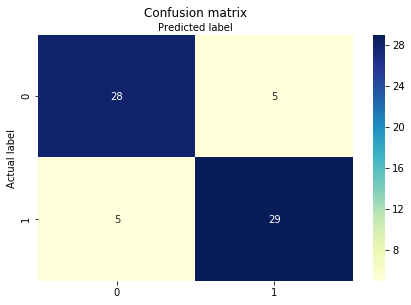

In [45]:
y_pred_season = logreg.predict(X_season)
utils.display_confusion_matrix(y_season,y_pred_season)



In [46]:
prediction_probabilities = logreg.predict_proba(X_season)
print("Accuracy:",metrics.accuracy_score(y_season, y_pred_season))
print("Precision:", metrics.precision_score(y_season,y_pred_season))
print("Recall:",metrics.recall_score(y_season, y_pred_season))
print("Log loss= ",log_loss(y_season, prediction_probabilities))

Accuracy: 0.8507462686567164
Precision: 0.8529411764705882
Recall: 0.8529411764705882
Log loss=  0.43456450085879683


In [47]:
missed_predictions = get_missed_predictions(tourney_comp_ratings, model_features, numeric_model_features, 
                                            prediction_probabilities,X_season,y_season,y_pred_season)

                               North Carolina                  Texas A&M     Stat Supports Winner
Allow PPG                       73.00                              70.00         True  (L)
FG %                            45.70                              46.00         True  (H)
Def Rb Avg                      28.00                              29.00         True  (H)
FT ATT Avg                      18.00                              19.00         True  (H)
Seed                              2                                  7          False  (L)
SAG                              8.00                              27.00        False  (L)
WLK                              7.00                              28.00        False  (L)
WOL                              8.00                              29.00        False  (L)
RTH                              9.00                              27.00        False  (L)
COL                              9.00                              27.00        Fal

In [48]:
missed_predictions

,season_t,round,game_date,seed_t,team_t,team_id_t,win_pts,seed_o,team_o,team_id_o,lose_pts,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_mor,predicted_result,pred_win_prob,supporting_features,supporting_model_features,features,model_features,game_index
1022,2018,32,2018-03-01 00:00:00.0000000,2,North Carolina,e9ca48b2-00ba-41c0-a02b-6885a2da1ff1,86,7,Texas A&M,ef184799-d79b-49d9-a662-991eaf4044cd,65,-1,2017,Lose,20.08,11.78,0.703,81.0,73.0,0.457,0.743,84.670270,13.0,28.0,12.0,5.0,95.665220,18.0,15.30,10.62,0.629,75.0,70.0,0.460,0.661,81.960000,12.0,29.0,13.0,5.0,91.508053,19.0,Atlantic Coast,Southeastern,8,7.0,8,9,9.0,7.0,10.0,4.0,7,27,28.0,29,27,27.0,30.0,28.0,29.0,28,0,0,0,8.0,5.0,18.150423,-0.000860,2.476234,-2.676007,0.082,7.0,8.0,-2.505742,0.003020,26.346452,-3.672601,-36.814701,52.579125,7.711031,-1319.175069,-1342.500459,-1316.017881,-1329.138264,-1116.504251,-1578.622750,-1165.074495,-1531.501919,1,0.801996,"[fg_pct, def_rebs_avg, ft_att_avg]","[fg_pct, def_rebs_avg, ft_att_avg]",13.636364,14.285714,1022
1038,2018,16,2018-03-01 00:00:00.0000000,2,Purdue,12d7f888-675b-459f-9099-a38f771d8a95,78,3,Texas Tech,f8c705b7-87d3-411a-9c8b-5124daab0469,65,-1,2017,Lose,23.41,8.74,0.811,80.0,65.0,0.493,0.743,75.535135,8.0,26.0,10.0,5.0,105.910978,20.0,19.38,9.60,0.730,74.0,64.0,0.460,0.704,77.816216,10.0,25.0,12.0,7.0,95.095860,22.0,Big Ten,Big 12,5,4.0,9,8,10.0,5.0,5.0,9.0,4,13,13.0,18,14,19.0,12.0,14.0,23.0,10,0,0,0,15.0,10.0,30.434848,0.000289,-5.071393,2.522555,0.039,5.0,5.0,-0.007673,0.003992,68.750953,-7.263362,-6.980332,44.236497,-6.208460,-553.104134,-573.255769,-561.898785,-440.011988,-556.416448,-477.970251,-580.712439,-434.829010,1,0.777339,"[off_rebs_avg, ft_att_avg, sos]","[off_rebs_avg, ft_att_avg, sos]",13.636364,14.285714,1038
988,2018,64,2018-03-01 00:00:00.0000000,4,Arizona,9b166a3f-e64b-4825-bb6b-92c6f0418263,89,13,Buffalo,a9f5c9a2-342c-4881-9996-5d5c05ec9bd9,68,-1,2017,Lose,15.67,6.84,0.771,80.0,71.0,0.504,0.760,77.868571,10.0,26.0,12.0,4.0,102.737213,21.0,7.99,0.25,0.750,84.0,76.0,0.473,0.699,84.944444,11.0,26.0,12.0,6.0,98.888162,19.0,Pacific 12,Mid-American,16,19.0,19,20,11.0,21.0,19.0,13.0,15,73,68.0,55,79,43.0,76.0,72.0,25.0,78,1,0,1,9.0,8.0,5.865998,0.000225,-2.555518,-0.076726,0.061,8.0,6.0,4.988466,-0.004337,24.384059,7.099679,-66.649071,84.837289,45.128275,-3965.601932,-3137.404737,-2258.666751,-4366.986377,-1987.751945,-3779.927749,-3437.593601,-4602.186065,1,0.757597,"[off_rebs_avg, to_net_avg]","[off_rebs_avg, to_net_avg]",9.090909,9.523810,988
1024,2018,32,2018-03-01 00:00:00.0000000,5,Ohio St,857462b3-0ab6-4d26-9669-10ca354e382b,90,4,Gonzaga,2f4d21f8-6d5f-48a5-abca-52a30583871a,84,-1,2017,Lose,17.67,9.03,0.735,76.0,67.0,0.480,0.731,77.217647,9.0,26.0,11.0,6.0,98.423097,18.0,18.43,2.59,0.865,83.0,67.0,0.498,0.708,80.297297,10.0,28.0,11.0,6.0,103.365870,19.0,Big Ten,West Coast,22,16.0,21,19,18.0,15.0,13.0,20.0,16,10,11.0,10,11,17.0,8.0,12.0,21.0,11,1,0,0,9.0,16.0,-43.271702,-0.001339,-2.555518,-5.275288,0.023,5.0,5.0,-0.007673,-0.025298,-31.611081,-3.672601,7.936853,-9.045091,44.094649,839.752110,324.196370,694.966375,597.302002,65.903334,485.100686,68.578734,369.397790,1,0.691175,"[margin_victory_avg, fg_pct, off_re

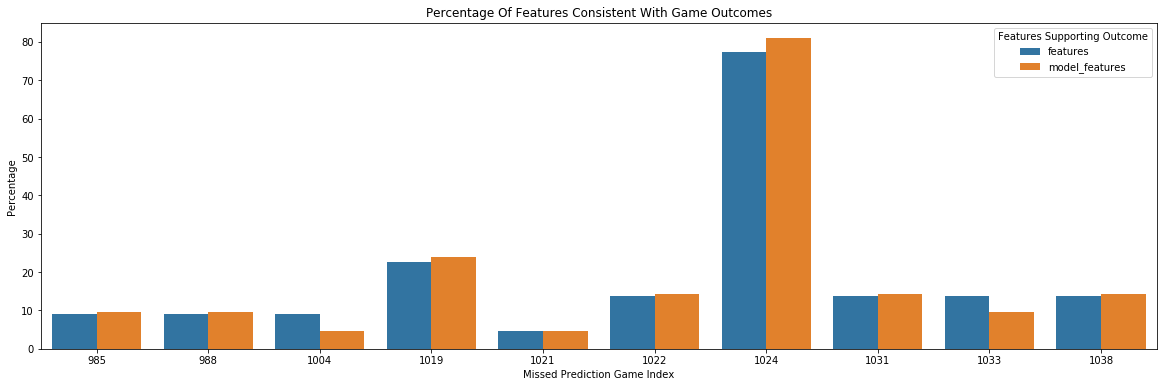

In [49]:
plot_missed_predictions_df = missed_predictions[['game_index','features','model_features']]
plot_missed_predictions_df = pd.melt(plot_missed_predictions_df, id_vars='game_index', var_name= 'Features Supporting Outcome')
m_plot = sns.barplot(x='game_index', y='value', hue='Features Supporting Outcome', data= plot_missed_predictions_df) 
plt.title("Percentage Of Features Consistent With Game Outcomes")
plt.ylabel('Percentage')
plt.xlabel('Missed Prediction Game Index')
m_plot.figure.set_size_inches(20,6)

In [59]:
missed_predictions[missed_predictions['game_index']==1024]

,season_t,round,game_date,seed_t,team_t,team_id_t,win_pts,seed_o,team_o,team_id_o,lose_pts,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_mor,predicted_result,pred_win_prob,supporting_features,supporting_model_features,features,model_features,game_index
1024,2018,32,2018-03-01 00:00:00.0000000,5,Ohio St,857462b3-0ab6-4d26-9669-10ca354e382b,90,4,Gonzaga,2f4d21f8-6d5f-48a5-abca-52a30583871a,84,-1,2017,Lose,17.67,9.03,0.735,76.0,67.0,0.48,0.731,77.217647,9.0,26.0,11.0,6.0,98.423097,18.0,18.43,2.59,0.865,83.0,67.0,0.498,0.708,80.297297,10.0,28.0,11.0,6.0,103.36587,19.0,Big Ten,West Coast,22,16.0,21,19,18.0,15.0,13.0,20.0,16,10,11.0,10,11,17.0,8.0,12.0,21.0,11,1,0,0,9.0,16.0,-43.271702,-0.001339,-2.555518,-5.275288,0.023,5.0,5.0,-0.007673,-0.025298,-31.611081,-3.672601,7.936853,-9.045091,44.094649,839.75211,324.19637,694.966375,597.302002,65.903334,485.100686,68.578734,369.39779,1,0.691175,"[margin_victory_avg, fg_pct, off_rebs_avg, def...","[margin_victory_avg, fg_pct, off_rebs_avg, def...",77.272727,80.952381,1024


In [50]:
#Note that the probability of the first team winning is returned in the 2nd column of the prediction_probabilities array

log_loss_result = utils.compute_log_loss(y_season.values, prediction_probabilities[:,1] )
log_loss_result

0.43456450085879683

In [51]:
prediction_probabilities[:,1]

array([0.8479311 , 0.40631815, 0.78081139, 0.12320667, 0.00335724,
       0.24436524, 0.97009851, 0.75759721, 0.89869378, 0.19312798,
       0.62293076, 0.26565372, 0.97115325, 0.01786156, 0.98072679,
       0.08569772, 0.92688088, 0.47034235, 0.57039629, 0.17532031,
       0.99840837, 0.01371931, 0.97194175, 0.59510856, 0.94077601,
       0.36783367, 0.64975301, 0.35045562, 0.99081214, 0.02269809,
       0.98075777, 0.09903368, 0.86857604, 0.16461477, 0.59516766,
       0.20406845, 0.79877876, 0.48973517, 0.35068132, 0.13072588,
       0.24058818, 0.8019961 , 0.95569562, 0.6911747 , 0.99783572,
       0.16871476, 0.72631389, 0.13243584, 0.95206535, 0.09754581,
       0.25475547, 0.45656055, 0.34046441, 0.43377937, 0.67586357,
       0.06178784, 0.98960819, 0.77733905, 0.94854377, 0.23500512,
       0.57689849, 0.14826878, 0.98860199, 0.24189442, 0.89646004,
       0.11146618, 0.94424019])

#### What predictions were counter to seeding?

In [52]:
y_pred_season

array([ 1, -1,  1, -1, -1, -1,  1,  1,  1, -1,  1, -1,  1, -1,  1, -1,  1,
       -1,  1, -1,  1, -1,  1,  1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,
        1, -1,  1, -1, -1, -1, -1,  1,  1,  1,  1, -1,  1, -1,  1, -1, -1,
       -1, -1, -1,  1, -1,  1,  1,  1, -1,  1, -1,  1, -1,  1, -1,  1],
      dtype=int64)

In [53]:
tourney_games = tourney_comp_ratings[tourney_comp_ratings.index.isin(X_season.index)].copy()
tourney_games

,season_t,round,game_date,seed_t,team_t,team_id_t,win_pts,seed_o,team_o,team_id_o,lose_pts,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_mor
981,2018,68,2018-03-01 00:00:00.0000000,16,Radford,f2cf9ba2-ac8c-4d92-8e7a-48dd88e8f40b,71,16,Long Island University,82c12e8d-7c6c-47d8-b100-3cbc190d268e,61,1,2017,Win,-2.61,-4.08,0.639,67.0,64.0,0.425,0.725,74.627778,11.0,23.0,12.0,6.0,89.778903,17.0,-8.61,-8.19,0.514,77.0,76.0,0.455,0.696,81.868571,10.0,27.0,14.0,5.0,94.053186,22.0,Big South,Northeast,191,170.0,149,184,160.0,170.0,158.0,128.0,165,256,242.0,234,266,239.0,252.0,243.0,232.0,205,0,0,0,3.0,1.0,2.0,-0.030,1.0,-4.0,0.029,6.0,9.0,-3.0,0.125,-4.274284,-5.0,0.0,6.00,4.11,-65.0,-72.0,-85.0,-82.0,-79.0,-82.0,-85.0,-40.0
982,2018,68,2018-03-01 00:00:00.0000000,11,UCLA,ec0d6b67-4b16-4b50-92b2-1a651dae6b0f,65,11,St. Bonaventure,22d90601-19d4-461b-a901-924d12f116ed,58,-1,2017,Lose,12.07,6.86,0.636,81.0,75.0,0.460,0.720,81.787879,10.0,28.0,12.0,5.0,99.036680,21.0,8.87,2.61,0.765,77.0,70.0,0.451,0.752,78.458824,10.0,25.0,11.0,7.0,98.140651,23.0,Pacific 12,Atlantic 10,44,44.0,49,46,35.0,48.0,51.0,36.0,54,60,59.0,33,62,32.0,69.0,44.0,24.0,60,1,0,0,6.0,7.0,-1.0,0.009,0.0,3.0,-0.032,7.0,4.0,3.0,-0.129,0.896029,-2.0,0.0,3.20,4.25,-16.0,-15.0,16.0,-16.0,3.0,-21.0,7.0,-6.0
983,2018,68,2018-03-01 00:00:00.0000000,16,Texas Southern,eb157f98-0697-459c-9293-ddb162ceb28b,64,16,North Carolina Central,e4c315a0-e83f-4d14-856e-34a0463059e3,46,1,2017,Win,-7.53,-5.53,0.444,77.0,79.0,0.438,0.725,81.288889,10.0,25.0,12.0,5.0,94.723893,25.0,-13.19,-12.31,0.543,72.0,69.0,0.461,0.687,79.822857,11.0,26.0,14.0,5.0,90.199728,17.0,Southwestern Athletic,Mid Eastern Athletic,242,240.0,265,296,249.0,249.0,276.0,222.0,256,295,296.0,280,313,278.0,309.0,293.0,279.0,310,0,0,0,-2.0,3.0,-5.0,-0.023,-1.0,-1.0,0.038,7.0,9.0,-2.0,-0.099,4.524165,8.0,0.0,5.66,6.78,-53.0,-56.0,-15.0,-17.0,-29.0,-60.0,-17.0,-54.0
984,2018,68,2018-03-01 00:00:00.0000000,11,Arizona State,ad4bc983-8d2e-4e6f-a8f9-80840a786c64,60,11,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,56,-1,2017,Lose,14.37,6.56,0.625,82.0,74.0,0.463,0.733,80.631250,9.0,25.0,10.0,6.0,101.697543,24.0,12.89,10.02,0.622,66.0,63.0,0.417,0.736,75.075676,11.0,25.0,12.0,6.0,87.911297,21.0,Pacific 12,Atlantic Coast,49,43.0,60,45,41.0,45.0,60.0,66.0,52,50,50.0,58,49,44.0,54.0,53.0,45.0,44,0,0,0,8.0,3.0,5.0,0.046,-2.0,0.0,-0.003,4.0,6.0,-2.0,0.003,13.786246,3.0,0.0,1.48,-3.46,-1.0,-7.0,2.0,-4.0,-3.0,-9.0,7.0,8.0
985,2018,64,2018-03-01 00:00:00.0000000,16,UMBC,32755362-6336-4dd3-ac34-6f72a6cc150b,74,1,Virginia,56913910-87f7-4ad7-ae3b-5cd9fb218fd9,54,1,2017,Win,-2.02,-3.84,0.694,73.0,68.0,0.443,0.646,77.344444,9.0,24.0,12.0,7.0,94.382991,17.0,22.21,9.07,0.912,67.0,54.0,0.460,0.754,68.070588,8.0,24.0,8.0,6.0,98.427238,13.0,America East,Atlantic Coast,189,168.0,125,176,140.0,184.0,123.0,111.0,155,2,2.0,1,1,1.0,1.0,1.0,1.0,1,0,1,1,5.0,13.0,-8.0,-0.017,1.0,0.0,-0.108,5.0,2.0,3.0,-0.218,-4.044247,4.0,15.0,-24.23,-12.91,187.0,166.0,124.0,175.0,139.0,183.0,122.0,154.0
986,2018,64,2018-03-01 00:00:00.0000000,15,Georgia St,94ea835b-8ce9-4de2-a5b1-971548fea974,68,2,Cincinnati,a17dfc54-415f-49c3-a2e6-d6fa9db18b0a,53,-1,2017,Lose,3.23,-2.78,0.686,74.0,67.0,0.461,0.

In [54]:
tourney_games['predicted'] = y_pred_season
tourney_games.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,win_pts,seed_o,team_o,team_id_o,lose_pts,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_mor,predicted
981,2018,68,2018-03-01 00:00:00.0000000,16,Radford,f2cf9ba2-ac8c-4d92-8e7a-48dd88e8f40b,71,16,Long Island University,82c12e8d-7c6c-47d8-b100-3cbc190d268e,61,1,2017,Win,-2.61,-4.08,0.639,67.0,64.0,0.425,0.725,74.627778,11.0,23.0,12.0,6.0,89.778903,17.0,-8.61,-8.19,0.514,77.0,76.0,0.455,0.696,81.868571,10.0,27.0,14.0,5.0,94.053186,22.0,Big South,Northeast,191,170.0,149,184,160.0,170.0,158.0,128.0,165,256,242.0,234,266,239.0,252.0,243.0,232.0,205,0,0,0,3.0,1.0,2.0,-0.030,1.0,-4.0,0.029,6.0,9.0,-3.0,0.125,-4.274284,-5.0,0.0,6.00,4.11,-65.0,-72.0,-85.0,-82.0,-79.0,-82.0,-85.0,-40.0,1
982,2018,68,2018-03-01 00:00:00.0000000,11,UCLA,ec0d6b67-4b16-4b50-92b2-1a651dae6b0f,65,11,St. Bonaventure,22d90601-19d4-461b-a901-924d12f116ed,58,-1,2017,Lose,12.07,6.86,0.636,81.0,75.0,0.460,0.720,81.787879,10.0,28.0,12.0,5.0,99.036680,21.0,8.87,2.61,0.765,77.0,70.0,0.451,0.752,78.458824,10.0,25.0,11.0,7.0,98.140651,23.0,Pacific 12,Atlantic 10,44,44.0,49,46,35.0,48.0,51.0,36.0,54,60,59.0,33,62,32.0,69.0,44.0,24.0,60,1,0,0,6.0,7.0,-1.0,0.009,0.0,3.0,-0.032,7.0,4.0,3.0,-0.129,0.896029,-2.0,0.0,3.20,4.25,-16.0,-15.0,16.0,-16.0,3.0,-21.0,7.0,-6.0,-1
983,2018,68,2018-03-01 00:00:00.0000000,16,Texas Southern,eb157f98-0697-459c-9293-ddb162ceb28b,64,16,North Carolina Central,e4c315a0-e83f-4d14-856e-34a0463059e3,46,1,2017,Win,-7.53,-5.53,0.444,77.0,79.0,0.438,0.725,81.288889,10.0,25.0,12.0,5.0,94.723893,25.0,-13.19,-12.31,0.543,72.0,69.0,0.461,0.687,79.822857,11.0,26.0,14.0,5.0,90.199728,17.0,Southwestern Athletic,Mid Eastern Athletic,242,240.0,265,296,249.0,249.0,276.0,222.0,256,295,296.0,280,313,278.0,309.0,293.0,279.0,310,0,0,0,-2.0,3.0,-5.0,-0.023,-1.0,-1.0,0.038,7.0,9.0,-2.0,-0.099,4.524165,8.0,0.0,5.66,6.78,-53.0,-56.0,-15.0,-17.0,-29.0,-60.0,-17.0,-54.0,1
984,2018,68,2018-03-01 00:00:00.0000000,11,Arizona State,ad4bc983-8d2e-4e6f-a8f9-80840a786c64,60,11,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,56,-1,2017,Lose,14.37,6.56,0.625,82.0,74.0,0.463,0.733,80.631250,9.0,25.0,10.0,6.0,101.697543,24.0,12.89,10.02,0.622,66.0,63.0,0.417,0.736,75.075676,11.0,25.0,12.0,6.0,87.911297,21.0,Pacific 12,Atlantic Coast,49,43.0,60,45,41.0,45.0,60.0,66.0,52,50,50.0,58,49,44.0,54.0,53.0,45.0,44,0,0,0,8.0,3.0,5.0,0.046,-2.0,0.0,-0.003,4.0,6.0,-2.0,0.003,13.786246,3.0,0.0,1.48,-3.46,-1.0,-7.0,2.0,-4.0,-3.0,-9.0,7.0,8.0,-1
985,2018,64,2018-03-01 00:00:00.0000000,16,UMBC,32755362-6336-4dd3-ac34-6f72a6cc150b,74,1,Virginia,56913910-87f7-4ad7-ae3b-5cd9fb218fd9,54,1,2017,Win,-2.02,-3.84,0.694,73.0,68.0,0.443,0.646,77.344444,9.0,24.0,12.0,7.0,94.382991,17.0,22.21,9.07,0.912,67.0,54.0,0.460,0.754,68.070588,8.0,24.0,8.0,6.0,98.427238,13.0,America East,Atlantic Coast,189,168.0,125,176,140.0,184.0,123.0,111.0,155,2,2.0,1,1,1.0,1.0,1.0,1.0,1,0,1,1,5.0,13.0,-8.0,-0.017,1.0,0.0,-0.108,5.0,2.0,3.0,-0.218,-4.044247,4.0,15.0,-24.23,-12.91,187.0,166.0,124.0,175.0,139.0,183.0,122.0,154.0,-1


In [55]:
cond_1 = (tourney_games['seed_t'] > tourney_games['seed_o']) & (tourney_games['predicted'] == 1)
cond_2 = (tourney_games['seed_t'] < tourney_games['seed_o']) & (tourney_games['predicted'] == -1)

predictions_counter_seed = tourney_games[cond_1 | cond_2]
predictions_counter_seed[['round','seed_t','team_t','seed_o','team_o','game_result','predicted','win_pts','lose_pts']]

,round,seed_t,team_t,seed_o,team_o,game_result,predicted,win_pts,lose_pts
990,64,6,Miami,11,Loyola Chicago,-1,-1,64,62
992,64,8,Creighton,9,Kansas St,-1,-1,69,59
1000,64,8,Missouri,9,Florida St,-1,-1,67,54
1007,64,10,Butler,7,Arkansas,1,1,79,62
1008,64,8,Virginia Tech,9,Alabama,-1,-1,86,83
1014,64,6,TCU,11,Syracuse,-1,-1,57,52
1018,32,2,Cincinnati,7,Nevada,-1,-1,75,73
1024,32,5,Ohio St,4,Gonzaga,-1,1,90,84
1032,32,4,Auburn,5,Clemson,-1,-1,84,53
1034,16,7,Nevada,11,Loyola Chicago,-1,-1,69,68


In [56]:
# correct counter seed predictions
correct_counter_predictions = predictions_counter_seed[predictions_counter_seed['game_result']== predictions_counter_seed['predicted']]
correct_counter_predictions[['round','seed_t','team_t','seed_o','team_o','game_result','predicted','win_pts','lose_pts']]

,round,seed_t,team_t,seed_o,team_o,game_result,predicted,win_pts,lose_pts
990,64,6,Miami,11,Loyola Chicago,-1,-1,64,62
992,64,8,Creighton,9,Kansas St,-1,-1,69,59
1000,64,8,Missouri,9,Florida St,-1,-1,67,54
1007,64,10,Butler,7,Arkansas,1,1,79,62
1008,64,8,Virginia Tech,9,Alabama,-1,-1,86,83
1014,64,6,TCU,11,Syracuse,-1,-1,57,52
1018,32,2,Cincinnati,7,Nevada,-1,-1,75,73
1032,32,4,Auburn,5,Clemson,-1,-1,84,53
1034,16,7,Nevada,11,Loyola Chicago,-1,-1,69,68
1035,16,9,Florida St,4,Gonzaga,1,1,75,60


In [57]:
# incorrect counter seed predictions
wrong_counter_predictions = predictions_counter_seed[predictions_counter_seed['game_result'] != predictions_counter_seed['predicted']]
wrong_counter_predictions[['round','seed_t','team_t','seed_o','team_o','game_result','predicted','win_pts','lose_pts']]

,round,seed_t,team_t,seed_o,team_o,game_result,predicted,win_pts,lose_pts
1024,32,5,Ohio St,4,Gonzaga,-1,1,90,84


In [58]:
print("Number of counter seed predictions= ", len(predictions_counter_seed.index))
print("Number of correct counter seed predictions= ", len(correct_counter_predictions.index))

Number of counter seed predictions=  12
Number of correct counter seed predictions=  11
